In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()
from tensorflow.keras.layers import Dense
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras import models
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy import array
from numpy import argmax
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
import keras
import keras.utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import utils as np_utils
from tensorflow.keras.layers import BatchNormalization
#from keras import optimizers

In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


In [ ]:
zip_file = tf.keras.utils.get_file(origin='https://github.com/lizu444/breast-cancer-data/raw/main/breast%20cancer.zip', 
                                   fname='datasetv2.zip', extract=True)

1695744/1690207 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/breast cancer.zip"

Archive:  /content/drive/MyDrive/breast cancer.zip
   creating: Images/
   creating: Images/train/
   creating: Images/train/benign/
  inflating: Images/train/benign/mdb002rl_resized.jpg  
  inflating: Images/train/benign/mdb003ll_resized.jpg  
  inflating: Images/train/benign/mdb005ll_resized.jpg  
  inflating: Images/train/benign/mdb007ll_resized.jpg  
  inflating: Images/train/benign/mdb008rl_resized.jpg  
  inflating: Images/train/benign/mdb011ll_resized.jpg  
  inflating: Images/train/benign/mdb012rl_resized.jpg  
  inflating: Images/train/benign/mdb013ll_resized.jpg  
  inflating: Images/train/benign/mdb016rm_resized.jpg  
  inflating: Images/train/benign/mdb017ls_resized.jpg  
  inflating: Images/train/benign/mdb018rs_resized.jpg  
  inflating: Images/train/benign/mdb019ll_resized.jpg  
  inflating: Images/train/benign/mdb020rl_resized.jpg  
  inflating: Images/train/benign/mdb021ll_resized.jpg  
  inflating: Images/train/benign/mdb022rm_resized.jpg  
  inflating: Images/train/b

In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), '/content/drive/MyDrive/Images')
train_dir = os.path.join(data_dir, '/content/drive/MyDrive/Images/train')
validation_dir = os.path.join(data_dir, '/content/drive/MyDrive/Images/validation')

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/drive/MyDrive/Images/train : 256files
total images for validation : /content/drive/MyDrive/Images/validation : 64files


In [ ]:
import json

with open('/content/drive/MyDrive/label/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['malignent', 'benign']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 2


In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 64 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()


Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 22,852,898
Trainable params: 1,050,114
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
4/4 [==============================] - 90s 12s/step - loss: 2.5011 - accuracy: 0.4568 - val_loss: 1.6159 - val_accuracy: 0.3125
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 1.4461 - accuracy: 0.4385 - val_loss: 0.7542 - val_accuracy: 0.3281
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.8322 - accuracy: 0.4578 - val_loss: 0.7067 - val_accuracy: 0.6875
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 0.8829 - accuracy: 0.5656 - val_loss: 0.6033 - val_accuracy: 0.6875
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.7124 - accuracy: 0.5104 - val_loss: 0.7680 - val_accuracy: 0.3125
Epoch 6/30
4/4 [==============================] - 5s 1s/step - loss: 0.7599 - accuracy: 0.4182 - val_loss: 0.6590 - val_accuracy: 0.6875
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.6780 - accuracy: 0.5536 - val_loss: 0.5994 - val_accuracy: 0.6875
Epoch 8/30
4/4 [=======================

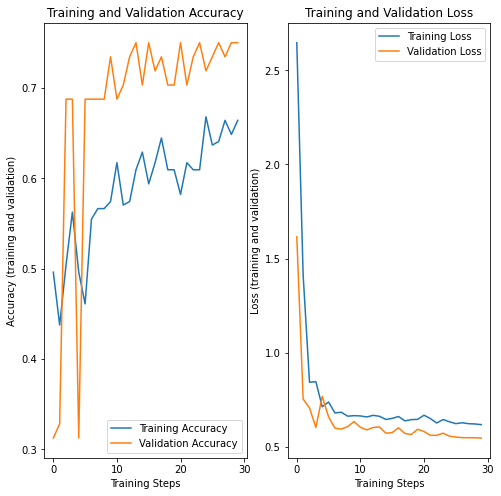

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: malignent, file: malignent/mdb284rm_resized.jpg
PREDICTED: class: benign, confidence: 0.626447


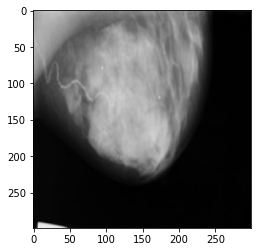

<Figure size 432x288 with 0 Axes>

SOURCE: class: malignent, file: malignent/mdb248rl_resized.jpg
PREDICTED: class: malignent, confidence: 0.543050


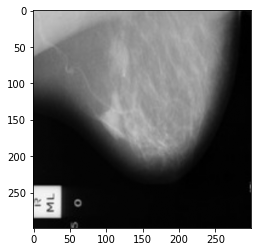

SOURCE: class: benign, file: benign/mdb256rl_resized.jpg
PREDICTED: class: malignent, confidence: 0.716098


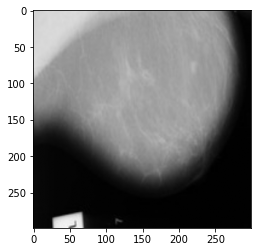

<Figure size 432x288 with 0 Axes>

SOURCE: class: benign, file: benign/mdb084rl_resized.jpg
PREDICTED: class: malignent, confidence: 0.736866


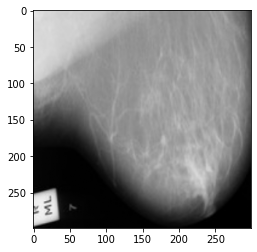

<Figure size 432x288 with 0 Axes>

SOURCE: class: benign, file: benign/mdb237lm_resized.jpg
PREDICTED: class: malignent, confidence: 0.815216


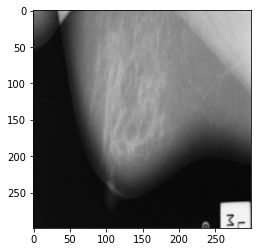

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()